In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
train_img, test_img, train_lbl, test_lbl = train_test_split( mnist.data, mnist.target, test_size = 1/7.0, random_state = 0)

Scaling data:
 so you need to scale the features in the data before applying PCA. You can transform the data onto unit scale (mean = 0 and variance = 1), which is a requirement for the optimal performance of many machine learning algorithms 

In [33]:
scaler = StandardScaler()
#Fit on Training set
print(train_img.shape)
print(test_img.shape)
scaler.fit(train_img) #calculate fit and variance

#apply transform to training and test set
train_img = scaler.transform(train_img) #transform features in each of the data
test_img = scaler.transform(test_img)

(60000, 327)
(10000, 327)


## Apply PCA

In [34]:
from sklearn.decomposition import PCA

pca = PCA(.90) #.95 means that 95% of the variance is retained
pca.fit(train_img) # calculate mean and variance
print(pca.n_components_)




295


In [35]:
train_img_trans = pca.transform(train_img)
test_img_trans = pca.transform(test_img) #transform test and train data
print(train_img_trans.shape)

revert = pca.inverse_transform(train_img_trans)
print(revert.shape)
revert = pca.inverse_transform(test_img_trans)
print(revert.shape)

(60000, 295)
(60000, 327)
(10000, 327)


## test run

In [9]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import Dataset

import math
import matplotlib.pyplot as plt

torch.manual_seed(111) # This is so this experiment can be replicated

## Preparing Data

Importing Data

In [63]:
training_data = pd.read_csv('small_sample.csv')
training_data.head()

,USID,1,2,3,4,5,6,7,8,9,...,Laser_Energy,Laser_Shots,Laser_StdDev,Phase,TIC,Max_Bin_Counts,Charge_Control,category_label,sample_label,formationprocess_label
0,8529000049,0,0,0,0,0,0,0,0,0,...,27.993000,2,0.193500,1,1233,82,0.01,CsI,CsI,Standards
1,8464000004,0,0,0,0,0,0,0,0,0,...,29.386200,5,0.971686,1,1714,97,0.01,CsI,CsI,Standards
2,8551000046,0,0,0,0,0,0,0,0,0,...,23.499500,1,0.000000,1,268,25,0.01,CsI,CsI,Standards
3,8710000047,0,0,0,0,0,0,0,0,0,...,28.401501,2,0.021500,1,4873,120,0.01,CsI,CsI,Standards
4,8521000068,0,0,0,0,0,0,0,0,0,...,50.678699,1,0.000000,3,473,25,5.00,CsI,CsI,Standards


## Dataset Class

In [62]:
class MassSpecDataset(Dataset):
    """ Mass Spectrometry Dataset. """

    def __init__ (self, csv_file):
        """Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample."""
        self.msdata = pd.read_csv(csv_file)
        #self.transform = transform
        self.features = self.msdata.drop(columns=['USID', 'category_label', 'sample_label', 'formationprocess_label'])
        #self.features = self.features.drop(columns=self.features.loc[:,'1050':'2000'].columns, axis = 1)
        print(self.features.head())
    def __len__(self):
        return len(self.msdata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.features.iloc[idx].values
        sample = torch.tensor(sample, dtype = torch.float32)

        return sample

        

## Generator and Discriminator Class:

In [44]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128), #128 input layers
            torch.nn.ReLU(), #ReLU activation function
            torch.nn.Linear(128, output_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        return self.network(x)

class Discriminator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

## Parameters

In [64]:
from torch.utils.data import DataLoader
dataset = MassSpecDataset('small_sample.csv')
feature_dim = dataset.features.shape[1]  # Number of features in the dataset
batch_size = 32
epochs = 100
lr = 0.000
input_dim = 1056


   1  2  3  4  5  6  7  8  9  10  ...  1047  1048  1049  Laser_Energy  \
0  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     27.993000   
1  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     29.386200   
2  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     23.499500   
3  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     28.401501   
4  0  0  0  0  0  0  0  0  0   0  ...     0     0     0     50.678699   

   Laser_Shots  Laser_StdDev  Phase   TIC  Max_Bin_Counts  Charge_Control  
0            2      0.193500      1  1233              82            0.01  
1            5      0.971686      1  1714              97            0.01  
2            1      0.000000      1   268              25            0.01  
3            2      0.021500      1  4873             120            0.01  
4            1      0.000000      3   473              25            5.00  

[5 rows x 1056 columns]


In [65]:
generator = Generator(input_dim, feature_dim)
discriminator = Discriminator(feature_dim)

In [66]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = lr)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = lr)
loss_function = torch.nn.BCELoss()


## Data Training Begins Now

In [67]:
for epoch in range(100):
    for n, real_samples in enumerate(dataloader):
        print(real_samples.size(0))
        batch_size = real_samples.size(0)

        # Real and Fake Data Labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)


        #Fake Data
        noise = torch.randn(batch_size, input_dim)
        fake_samples = generator(noise)
        
        
        #print(real_samples.shape, fake_samples.shape)
        
        
        all_samples = torch.cat((real_samples, fake_samples))
        all_samples_labels = torch.cat((real_labels, fake_labels))
        
        # Train Discriminator
        optimizer_discriminator.zero_grad() # clear gradients
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward() # Gradient Descent
        optimizer_discriminator.step() # Step
        
        #Train Generator
        noise = torch.randn(batch_size, input_dim)
        
        optimizer_generator.zero_grad()
        generated_samples = generator(noise)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
       
        print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
        print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        
        

32
Epoch: 0 Loss D.: 0.3786030113697052
Epoch: 0 Loss G.: 0.7100300788879395
32
Epoch: 0 Loss D.: 0.36314061284065247
Epoch: 0 Loss G.: 0.7098745703697205
32
Epoch: 0 Loss D.: 0.41819509863853455
Epoch: 0 Loss G.: 0.7098972201347351
32
Epoch: 0 Loss D.: 0.357578843832016
Epoch: 0 Loss G.: 0.7083741426467896
32
Epoch: 0 Loss D.: 0.4284191429615021
Epoch: 0 Loss G.: 0.7103016376495361
32
Epoch: 0 Loss D.: 0.5402517318725586
Epoch: 0 Loss G.: 0.707763135433197
32
Epoch: 0 Loss D.: 0.4692656695842743
Epoch: 0 Loss G.: 0.7026129961013794
32
Epoch: 0 Loss D.: 0.4656577706336975
Epoch: 0 Loss G.: 0.7108680605888367
32
Epoch: 0 Loss D.: 0.45290279388427734
Epoch: 0 Loss G.: 0.7154833078384399
32
Epoch: 0 Loss D.: 0.545190155506134
Epoch: 0 Loss G.: 0.7077916264533997
32
Epoch: 0 Loss D.: 0.40889787673950195
Epoch: 0 Loss G.: 0.7089777588844299
32
Epoch: 0 Loss D.: 0.3880734443664551
Epoch: 0 Loss G.: 0.7070850133895874
16
Epoch: 0 Loss D.: 0.3786312937736511
Epoch: 0 Loss G.: 0.708728194236755

## Plot Data and Visualize results here

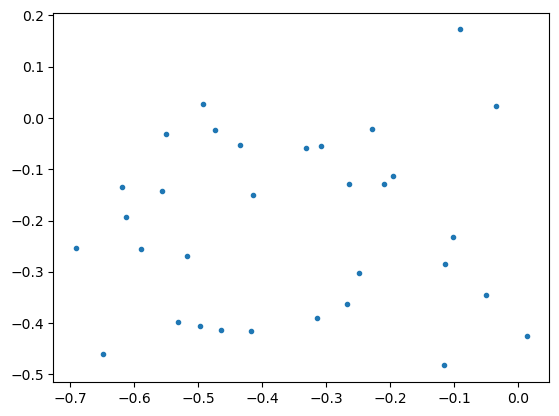

In [68]:
latent_space_samples = torch.randn(32, input_dim )
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 200], ".")